# CPU (scikit-learn) vs. GPU (cuML) random forest

Setup context manager for recording timings.

In [1]:
from time import time
from contextlib import contextmanager

times = []

@contextmanager
def timing(description: str) -> None:
    start = time()
    yield
    elapsed = time() - start
    times.append((description, elapsed))
    print(f"{description}: {round(elapsed)} seconds")

In [2]:
!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-01.csv > data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  655M  100  655M    0     0  74.4M      0  0:00:08  0:00:08 --:--:-- 71.5M


## CPU (scikit-learn)

The `pandas` and `scikit-learn` packages use the CPU for computations.

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RFCPU

with timing("CPU: CSV Load"):
    taxi_cpu = pd.read_csv(
        "data.csv",
        parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    )
    
X_cpu = (
    taxi_cpu[["PULocationID", "DOLocationID", "passenger_count"]]
    .fillna(-1)
)
y_cpu = (taxi_cpu["tip_amount"] > 1)

rf_cpu = RFCPU(n_estimators=100, n_jobs=-1)

with timing("CPU: Random Forest"):
    _ = rf_cpu.fit(X_cpu, y_cpu)

CPU: CSV Load: 13 seconds
CPU: Random Forest: 364 seconds


# GPU (cuML)

This section uses the `cudf` and `cuml` packages, which perform their computations using the GPU.

In [4]:
import cudf
from cuml.ensemble import RandomForestClassifier as RFGPU

with timing("GPU: CSV Load"):
    taxi_gpu = cudf.read_csv(
        "data.csv",
        parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    )
    
X_gpu = (
    taxi_gpu[["PULocationID", "DOLocationID", "passenger_count"]]
    .astype("float32")
    .fillna(-1)
)
y_gpu = (taxi_gpu["tip_amount"] > 1).astype("int32")

rf_gpu = RFGPU(n_estimators=100)

with timing("GPU: Random Forest"):
    _ = rf_gpu.fit(X_gpu, y_gpu)

GPU: CSV Load: 2 seconds
[W] [20:51:51.070745] Using experimental backend for growing trees

GPU: Random Forest: 18 seconds


# Comparison results

In [9]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

df = pd.DataFrame(times, columns=['description', 'Seconds'])
df[['Hardware', 'task']] = df.description.str.split(': ', 1, expand=True)

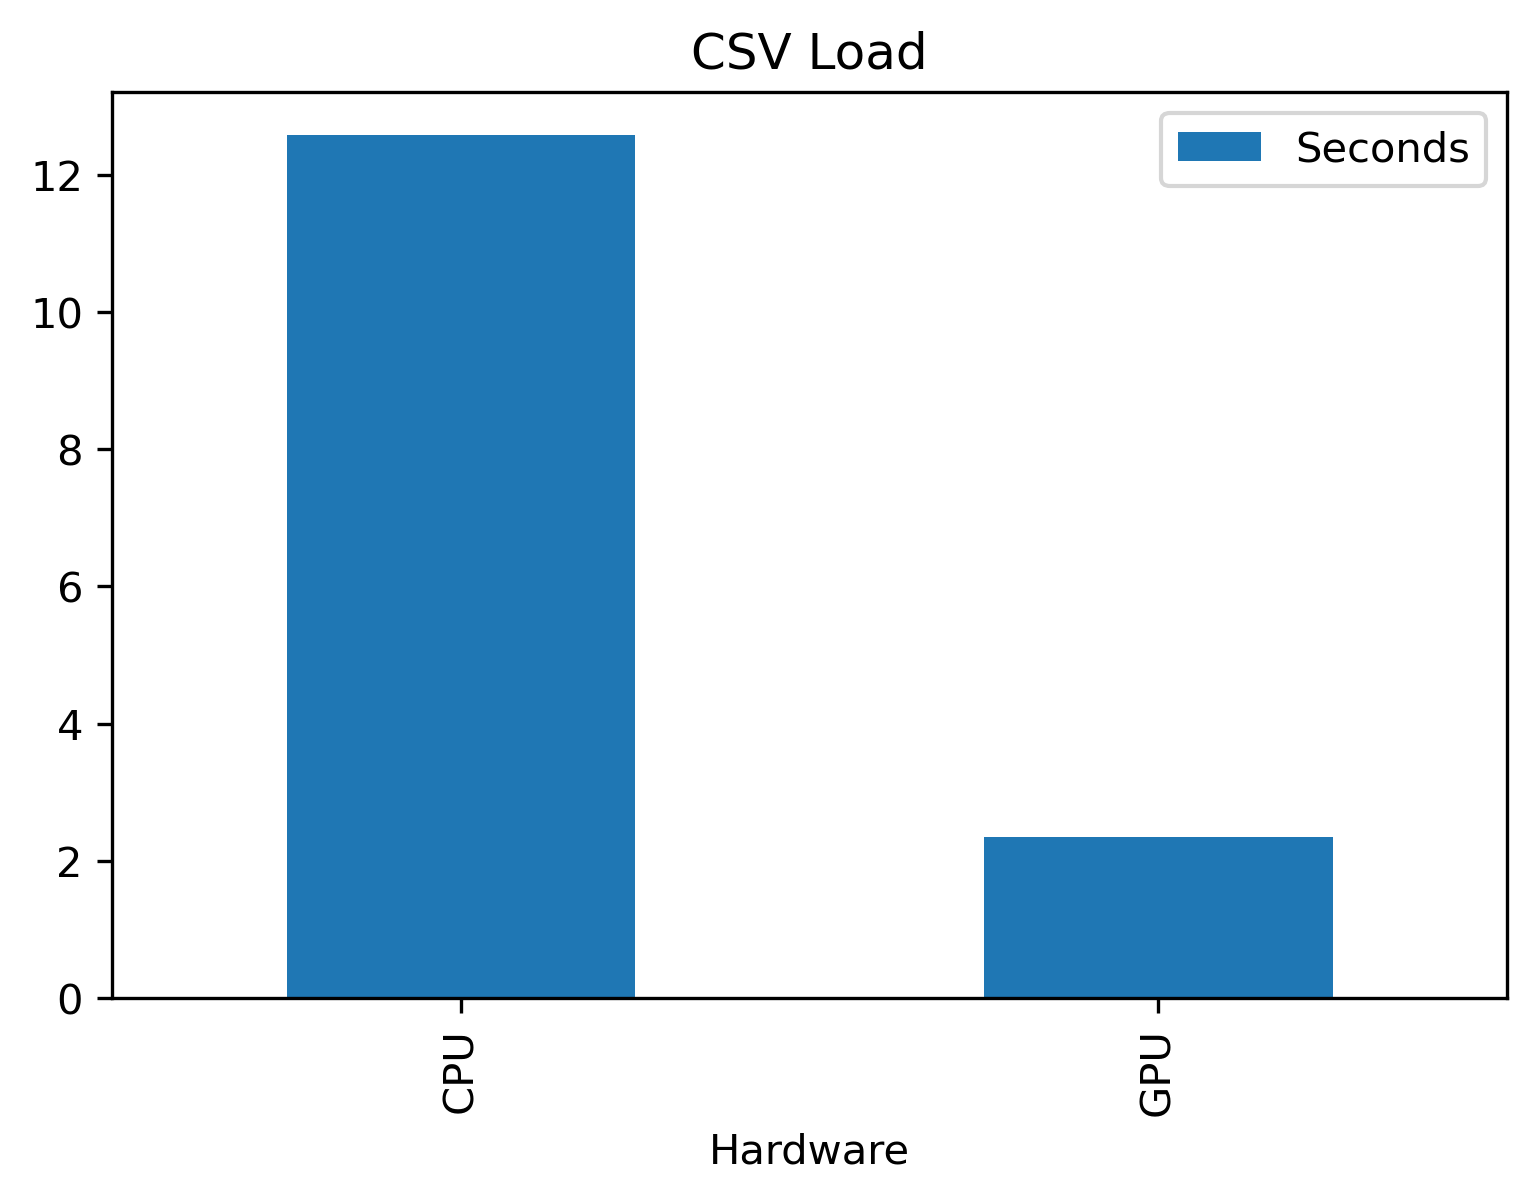

In [10]:
df[df.task == 'CSV Load'].plot(
    title='CSV Load', 
    kind='bar',
    x='Hardware', 
    y='Seconds',
);

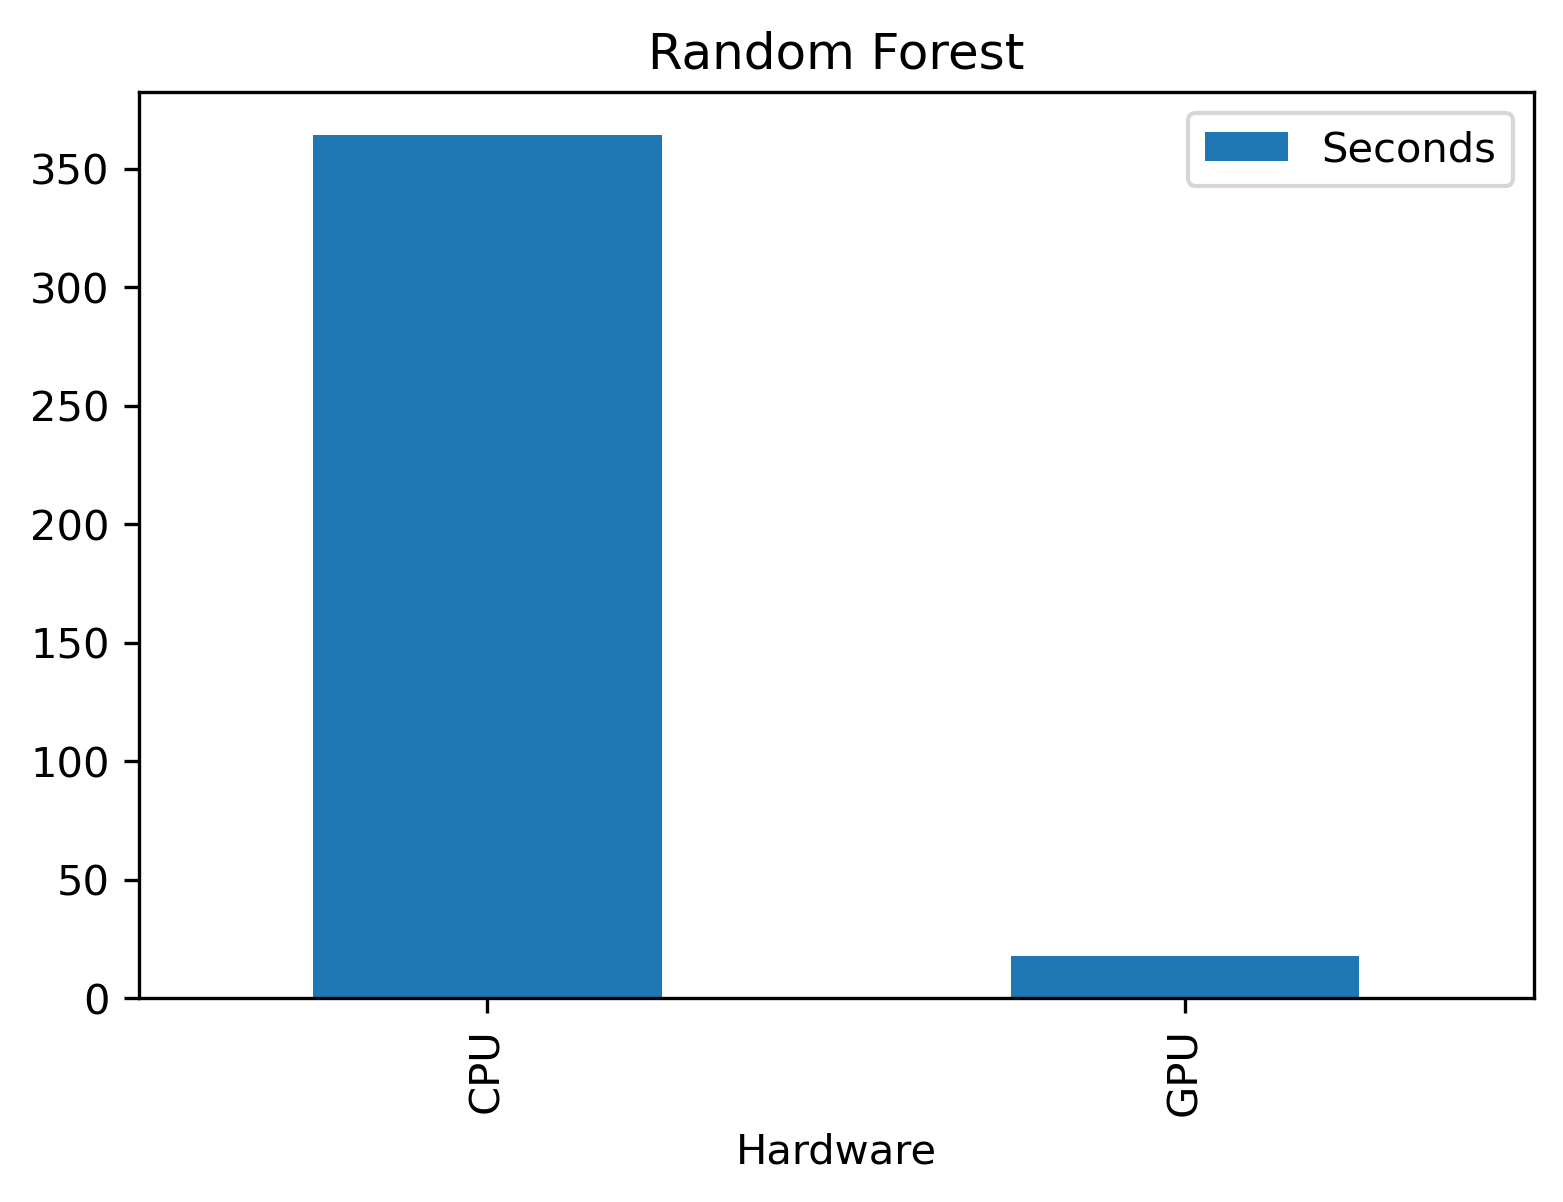

In [11]:
df[df.task == 'Random Forest'].plot(
    title='Random Forest',
    kind='bar', 
    x='Hardware',
    y='Seconds',
);

# Dask cluster

In [8]:
from dask.distributed import Client, wait
from dask_saturn import SaturnCluster
import dask_cudf
from cuml.dask.ensemble import RandomForestClassifier as RFDask

cluster = SaturnCluster()
client = Client(cluster)

taxi_dask = dask_cudf.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2019-*.csv",
    parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    storage_options={"anon": True},
    assume_missing=True,
)

X_dask = (
    taxi_dask[["PULocationID", "DOLocationID", "passenger_count"]]
    .astype("float32")
    .fillna(-1)
)
y_dask = (taxi_dask["tip_amount"] > 1).astype("int32")

X_dask, y_dask = client.persist([X_dask, y_dask])
_ = wait(X_dask)


rf_dask = RFDask(n_estimators=100)
_ = rf_dask.fit(X_dask, y_dask)

INFO:dask-saturn:Cluster is ready
INFO:dask-saturn:Registering default plugins
INFO:dask-saturn:{'tcp://192.168.107.196:39427': {'status': 'OK'}, 'tcp://192.168.254.132:36309': {'status': 'OK'}, 'tcp://192.168.86.68:34203': {'status': 'OK'}}
